# To test if the 2 state assumption gives the correct Pbnd

In [1]:
import Calculate_Pbnd_2statesAssumption as Calc_Pbnd_2states
import numpy as np
import Calculate_ABA_Finkelsteinlab_Diewertje as ABA
import matplotlib.pyplot as plt


In [2]:
# To load the data and check what it looks like
import numpy as np 
import pandas as pd
import Prepare_data as Pre

path = '../Data_ABA_Finkelsteinlab/' 
filename= 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'
data=pd.read_csv(path+filename)
xdata,ydata,yerr=Pre.Prepare_Cdata(path,filename)
#Wo I have the delta ABA = log(Kd)-ABA ontarget

In [3]:
paramBoyle=np.loadtxt('../Diewertje/parameters_Boyle.txt')
concentrations=np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref=1
mismatch_positions=xdata[0]
model_id='init_limit_general_energies_v2'
guide_length=20
T=10*60

In [4]:
import time
t1=time.time()
Pbnd_2states=Calc_Pbnd_2states.calc_Pbnd(paramBoyle,concentrations,ref,mismatch_positions)
t2=time.time()
diff_time=t2-t1
print('The time needed for calculation with 2 state assumption = ', diff_time)

[2.24855695e-02 6.74567084e-02 2.24855695e-01 6.74567084e-01
 2.24855695e+00 6.74567084e+00 2.24855695e+01 6.74567084e+01]
0.03465514362976294
<class 'numpy.float64'>
[5.71407131e-02 1.02111852e-01 2.59510838e-01 7.09222227e-01
 2.28321209e+00 6.78032598e+00 2.25202246e+01 6.74913635e+01]
The time needed for calculation with 2 state assumption =  0.0


In [5]:
Kon=[2.24855695e-01, 6.74567084e-01, 2.24855695e+00, 6.74567084e+00,
 2.24855695e+01, 6.74567084e+01, 2.24855695e+02, 6.74567084e+02]
Kon=np.array(Kon)
Koff=0.00012716753254655896

In [6]:
Kon/(Kon+Koff)

array([0.99943477, 0.99981152, 0.99994345, 0.99998115, 0.99999434,
       0.99999811, 0.99999943, 0.99999981])

In [7]:
1-np.exp(-(Kon+Koff))

array([0.2014701 , 0.49068788, 0.89446199, 0.99882419, 1.        ,
       1.        , 1.        , 1.        ])

In [8]:
Pbnd_2states

array([0.39351223, 0.66061585, 0.86645974, 0.95113641, 0.98482176,
       0.99488887, 0.99846115, 0.99948652])

In [9]:
len(paramBoyle)

44

In [10]:
#_,Pbnd_normal,_=ABA.calc_Pbound(paramBoyle,concentrations,ref,[])
#mismatch_positions=[]
parameters=paramBoyle
reference=1
from scipy import linalg
import sys
sys.path.append('../code_general/') # added this after we run it on the cluster
from read_model_ID import unpack_parameters
# Helper functions for executing the code below
def get_master_equation(parameters, mismatch_positions, model_id, guide_length):
    '''
    Construct rate matrix from given parameter set
    :param parameters:
    :param mismatch_positions:
    :param guide_length:
    :return:
    '''
    epsilon, forward_rates = unpack_parameters(parameters, model_id, guide_length)
    energies = get_energies(epsilon,mismatch_positions, guide_length)
    backward_rates = get_backward_rates(energies, forward_rates,guide_length )
    rate_matrix = build_rate_matrix(forward_rates, backward_rates) 
    return rate_matrix

def get_energies(epsilon,mismatch_positions, guide_length=20):
    '''
    For general (position dependent) model make a list with the energies at every bound state
    At positions with a mismatch incorporated: add mismatch penalty (epsI[mm_pos])

    So this function returns the minima in the energy lanscape (the actual energy at every state)

    :param epsilon: [epsPAM, epsC[state_1],....,epsC[state_N],epsI[state_1],...epsI[state_N] ]
    provide as np.array()
    :param mismatch_positions: each mismach position has a range [1,2, ... , 20]
    :return: vector with the minima in the landscape
    '''
    if type(mismatch_positions)==type([]):
        mismatch_positions = np.array(mismatch_positions)
    new_epsilon = epsilon.copy()
    epsI = np.array(new_epsilon[(guide_length+1):])
    energies = -1*np.array(new_epsilon[0:(guide_length+1)]) # convention: epsC>0 means downward slope
    energies[0] = new_epsilon[0]                 # convention: epsPAM>0 means upward slope
    if len(mismatch_positions)>0:
        energies[mismatch_positions.astype(int)] += epsI[(mismatch_positions.astype(int)-1)]
    energies=np.ndarray.tolist(energies)
    return energies


def get_backward_rates(energies, forward_rates,guide_length=20):
    '''
    Apply detailed balance condition to get the backward rates from the energies and forward rates

    :param energies:
    :param forward_rates:
    :param guide_length:
    :return:
    '''
    # 0) Construct array containing backward rates
    backward_rates = np.zeros(guide_length+2)

    # 1) Apply detailed balance condition:
    backward_rates[1:] = forward_rates[:-1] * np.exp(energies)

    # 2) No rate backward from solution state
    backward_rates[0] = 0.0
    return backward_rates


def build_rate_matrix(forward_rates, backward_rates):
    '''
    build matrix in Master Equation

    :param forward_rates:
    :param backward_rates:
    :return:
    '''
    diagonal1 = -(forward_rates + backward_rates)
    diagonal2 = backward_rates[1:]
    diagonal3 = forward_rates[:-1]
    # rate_matrix = np.zeros((len(forward_rates), len(forward_rates)))  # Build the matrix

    rate_matrix = np.diag(diagonal1, k=0) + np.diag(diagonal2, k=1) + np.diag(diagonal3, k=-1)

    return rate_matrix

def get_Probability(rate_matrix, initial_condition,T=12*3600):
    '''
    solves the Master Equation for a given initial condition and desired time point
    :param rate_matrix: matrix with rates that makes up the Master Equation
    :param initial_condition: vector with initial configuration
    :param T: Evaluate solution at time T
    :return:
    '''
    P0 = initial_condition
    M = rate_matrix
    matrix_exponent = linalg.expm(+M*T)
    return matrix_exponent.dot(P0)

# this is the code we execute
t1=time.time()
rate_matrix = get_master_equation(parameters, mismatch_positions, model_id, guide_length)
rel_concentration = concentrations/reference
everything_unbound = np.array([1.0] + [0.0] * (guide_length + 1))
Pbound = []
for c in rel_concentration:
    new_rate_matrix = rate_matrix.copy()
    new_rate_matrix[0][0] *= c
    new_rate_matrix[1][0] *= c
    Probability = get_Probability(new_rate_matrix, everything_unbound, T)
    Pbound.append(np.sum(Probability[1:]))
Pbound = np.array(Pbound)
t2=time.time()
diff_time=t2-t1
print('The time needed for the normal calculation = ',diff_time)

The time needed for the normal calculation =  0.015624523162841797


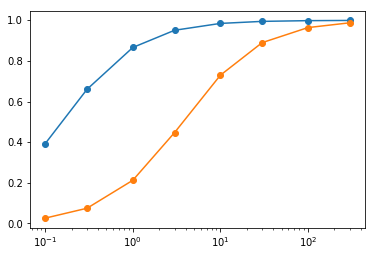

In [11]:
plt.plot(concentrations,Pbnd_2states,marker='o')
plt.plot(concentrations,Pbound,marker='o')
plt.xscale('log');

In [31]:
# To load other paramter sets, to choose one with low Ksp, to see if that will give a good fit.
import plotting_Boyle_Diewertje as plt_B
model_id = 'general_energies_no_kPR'
# filename = simset[np.argsort(chi_squared)[3]]
filename = np.array(['../data/22_3_2019/fit_22_3_2019_sim_4.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_5.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_6.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_7.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_9.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_13.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_17.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_21.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_26.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_31.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_33.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_35.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_47.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_49.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_50.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_51.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_53.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_54.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_56.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_59.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_63.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_67.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_68.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_69.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_79.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_80.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_82.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_83.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_87.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_90.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_97.txt'])
Nparams = 43
ref_Ksp=10000 # just a big number
for i in range(0,len(filename)):
    p= plt_B.load_simm_anneal(filename[i], Nparams)
    Ksp=10**p[-2]/10
    if(Ksp<ref_Ksp):
        ref_Ksp=Ksp
        parameters=p
        name=filename[i]


In [32]:
name

'../data/22_3_2019/fit_22_3_2019_sim_9.txt'

In [33]:
ref_Ksp

0.00038941973449552436

In [36]:
import time
t1=time.time()
Pbnd_2states_lowKsp=Calc_Pbnd_2states.calc_Pbnd(parameters,concentrations,ref,mismatch_positions)
t2=time.time()
diff_time=t2-t1
print('The time needed for calculation with 2 state assumption = ', diff_time)

[2.67370734e-02 8.02112201e-02 2.67370734e-01 8.02112201e-01
 2.67370734e+00 8.02112201e+00 2.67370734e+01 8.02112201e+01]
0.4427004669979888
<class 'numpy.float64'>
[ 0.46943754  0.52291169  0.7100712   1.24481267  3.1164078   8.46382247
 27.17977382 80.65392052]
The time needed for calculation with 2 state assumption =  0.01560068130493164


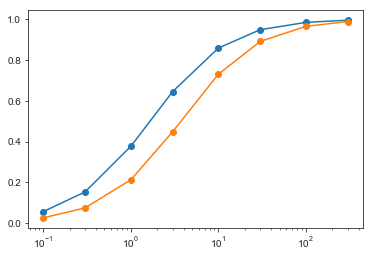

In [37]:
plt.plot(concentrations,Pbnd_2states_lowKsp,marker='o')
plt.plot(concentrations,Pbound,marker='o')
plt.xscale('log');

# The rates to use for testing the fit with 3 concentration points

In [42]:
rate_sol_to_PAM = 10**parameters[-2]
rate_internal = 10**parameters[-1]
print('S to P=',rate_sol_to_PAM)
print('internal rate=', rate_internal)

S to P= 0.0038941973449552435
internal rate= 471.7450318294534
